# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.interpolate import interp1d
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier




In [61]:
numerical = ['num_likes', 'num_comments', 'num_sent', 'sent_avg_length', 'num_words', 
             'num_unique_words', 'unique_words_percent', 'age', 'num_cats',
             'words_exist_per_cent',
             'shortlisted',
             'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 
             'emotion_sadness', 'emotion_surprise', 
             'sentiment_POSITIVE_no_prepro', 'sentiment_NEGATIVE_no_prepro', 
             'sentiment_hf_text']

txt_features = ['text_str', 'text_str_lem']

categories = [   'cat_Age', 'cat_Happy', 'cat_Thriller', 
                 'cat_Friendship', 'cat_East', 'cat_Inspirational', 
                 'cat_Christian', 'cat_Bedtime', 'cat_Drama', 'cat_Horror', 
                 'cat_Lesbian', 'cat_High', 'cat_Science', 'cat_American', 
                 'cat_Speculative', 'cat_Funny', 'cat_Adventure', 
                 'cat_Nonfiction', 'cat_African', 'cat_Christmas', 
                 'cat_Teens', 'cat_Fantasy', 'cat_Holiday', 'cat_Western', 
                 'cat_Young', 'cat_Coming', 'cat_Suspense', 'cat_Romance', 
                 'cat_Urban', 'cat_Latinx', 'cat_Desi', 'cat_Asian', 
                 'cat_Black', 'cat_Sad', 'cat_Kids', 'cat_People', 'cat_Color', 
                 'cat_Fiction', 'cat_Contemporary', 'cat_Mystery', 'cat_Adult', 
                 'cat_Transgender', 'cat_Historical', 'cat_Middle', 'cat_Gay', 
                 'cat_Indigenous', 'cat_Crime', 'num_cats', 'cat_School', 
                 'cat_Creative']

In [3]:
feats_to_keep = numerical + txt_features + categories

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("drive/MyDrive/Final Project/story_data_new_feats.csv", 
                 usecols=feats_to_keep)

In [6]:
target = 'num_likes'

# General features

## Preprocessing

In [62]:
numerical.remove('num_likes')
numerical.remove('num_comments')
numerical.remove('shortlisted')

In [63]:
X = df[numerical+categories]

In [64]:
y = df[target]

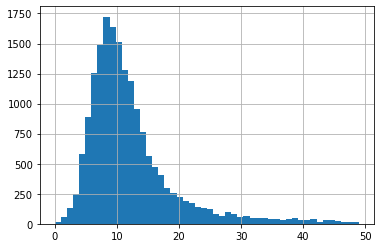

In [65]:
# TODO: to add this graph in the Medium article
df[df[target]<50][target].hist(bins=50)

In [66]:
# turn y into 0 and 1, given a threshold
threshold = np.quantile(y, 0.7)
threshold

13.0

In [67]:
print(f'It corresponds to {100*len(df[df[target]<=threshold][target])/len(df):.2f} percent of the stories being bad.')

It corresponds to 71.03 percent of the stories being bad.


In [68]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=threshold).fit(df[[target]])
y = bn.transform(df[[target]])

In [69]:
# log transform 
for var_to_log in ['sent_avg_length', 'num_unique_words', 'emotion_love']:
  X[var_to_log] = X[var_to_log].apply(np.log1p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
from sklearn.model_selection import train_test_split

test_size = 20/100

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14598, 67), (3650, 67), (14598, 1), (3650, 1))

In [71]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

X_train.shape, X_test.shape

((14598, 67), (3650, 67))

In [72]:
y_train = y_train.ravel()
y_test = y_test.ravel()

## Predictions

### Help functions

In [73]:
def display_model_results(model, X_train, X_test, y_train, y_test, name_model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # display R2
  print(f'R2 on train set: {model.score(X_train, y_train)}')
  print(f'R2 on test set: {model.score(X_test, y_test)}')
  print('\n')

  # classification report
  print(classification_report(y_test, y_pred))
  print('\n')

  # confusion matric
  print('Confusion matrix:')
  print(confusion_matrix(y_test, y_pred))
  print('\n')

  # roc
  y_probs = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
  auc = roc_auc_score(y_test, y_probs)

  plt.figure(figsize=(10,10))
  plt.plot(fpr, tpr, label=f'{name_model}, AUC={auc:.4f}')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
  plt.title("Receiver operating characteristic ")
  plt.xlabel('rate of false positives')
  plt.ylabel('rate of true positives')
  plt.legend(loc='best')
  plt.show()
  print('\n')


  # feature importance
  try:
    cols = [x for _, x in sorted(zip(model.coef_.tolist()[0], X_train.columns))]
    plt.figure(figsize=(15,15))
    for col, coef in zip(cols, sorted(model.coef_.tolist()[0])):
      plt.barh(col, coef)
  except AttributeError:
    print('No feature importance')
  return model


In [74]:
def play_with_threshold(recall_value, y_test, model, name):
  """
  Model must be trained
  """
  y_probs = model.predict_proba(X_test)[:,1]
  precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

  x = np.linspace(0,1, num=len(precision))
  y = interp1d(recall, precision)
  precision_value = y(recall_value)
  plt.figure(figsize=(10,10))
  plt.plot(recall, precision, label=name)
  plt.title("precision-recall curve")
  plt.plot(x, [precision_value]*len(recall), label=f'{precision_value:.2f}')
  plt.axvline(recall_value, label=f'{recall_value:.2f}')
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.legend()
  plt.show()

  if len(thresholds)<len(recall):
    thresholds = np.append(thresholds,0)
  y_thresholds = interp1d(recall, thresholds)
  threshold_value = y_thresholds(recall_value)
  print('\n')
  print(f'When recall is equal to {recall_value:.2f}, precision is equal to {precision_value:.2f},\
and the threshold is equal to {threshold_value:.2f}.')


### Logistic regression

R2 on train set: 0.7064666392656528
R2 on test set: 0.7219178082191781


              precision    recall  f1-score   support

           0       0.73      0.98      0.84      2648
           1       0.44      0.05      0.09      1002

    accuracy                           0.72      3650
   macro avg       0.59      0.51      0.46      3650
weighted avg       0.65      0.72      0.63      3650



Confusion matrix:
[[2587   61]
 [ 954   48]]




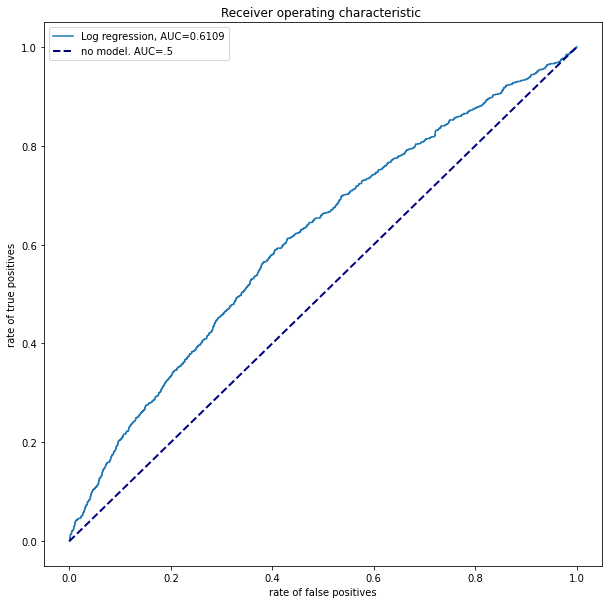

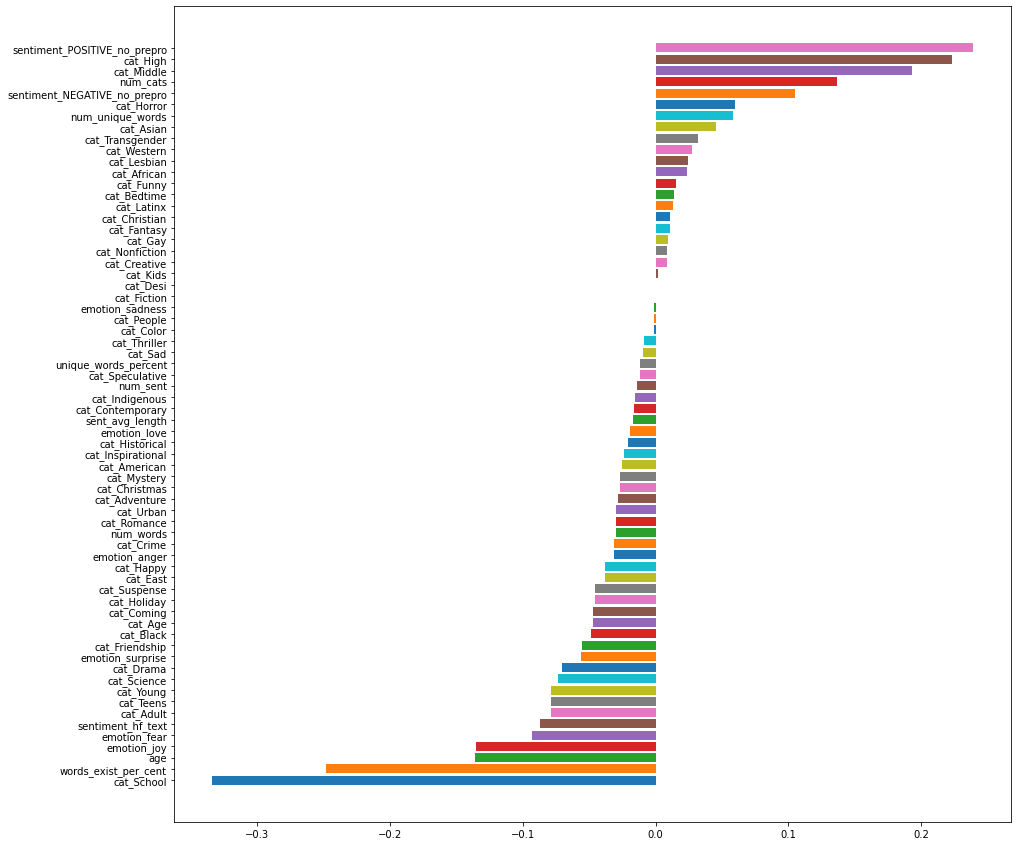

In [75]:
clf_log = display_model_results(LogisticRegression(), 
                      X_train, X_test, y_train, y_test, 
                      'Log regression')

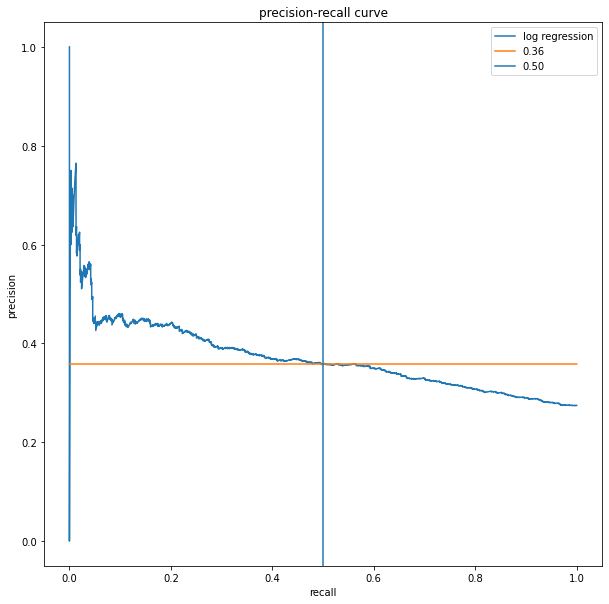



When recall is equal to 0.50, precision is equal to 0.36,and the threshold is equal to 0.31.


In [76]:
recall_value = 0.5 # chose wanted recall value
play_with_threshold(recall_value, y_test, clf_log, 'log regression')

### SVM

R2 on train set: 0.7175640498698452
R2 on test set: 0.7243835616438357


              precision    recall  f1-score   support

           0       0.73      0.99      0.84      2648
           1       0.44      0.01      0.03      1002

    accuracy                           0.72      3650
   macro avg       0.58      0.50      0.43      3650
weighted avg       0.65      0.72      0.62      3650



Confusion matrix:
[[2629   19]
 [ 987   15]]




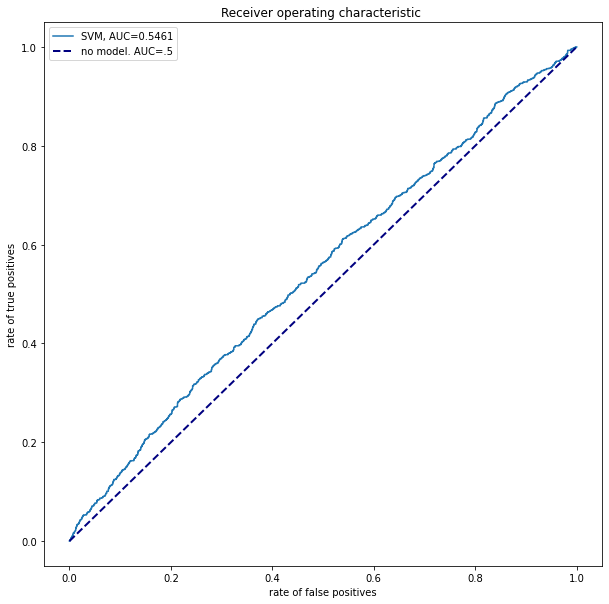



No feature importance


In [77]:
clf_svm = display_model_results(SVC(probability=True), 
                      X_train, X_test, y_train, y_test, 
                      'SVM')

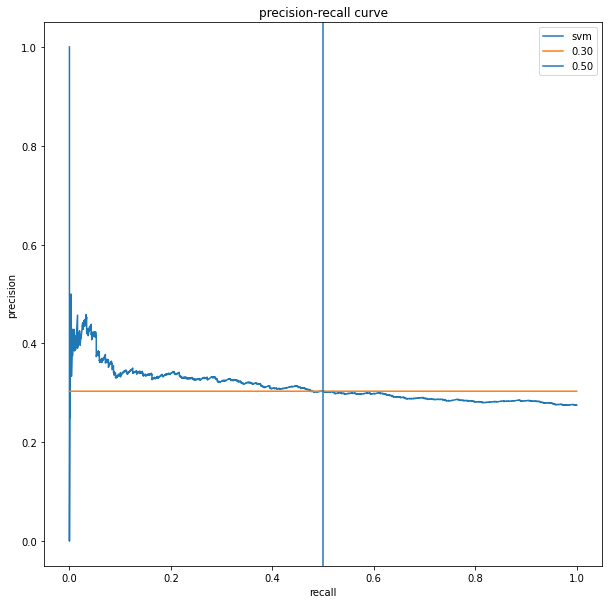



When recall is equal to 0.50, precision is equal to 0.30,and the threshold is equal to 0.28.


In [78]:
recall_value = 0.5 # chose wanted recall value
play_with_threshold(recall_value, y_test, clf_svm, 'svm')

### KNN 

k that minimizes the validation set error: 18


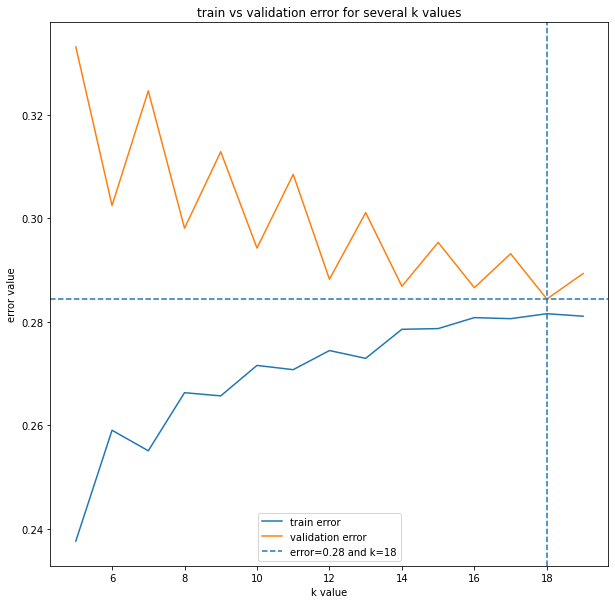

In [79]:
errors_train = []
errors_val = []
k_values = list(range(5, 20))

for k in k_values:
  neigh = KNeighborsClassifier(k)
  neigh.fit(X_train, y_train)
  error_train = 1 - neigh.score(X_train, y_train) 
  error_val   = 1 - neigh.score(X_test, y_test) 
  errors_train.append(error_train)
  errors_val.append(error_val)

k_best = k_values[errors_val.index(min(errors_val))]
plt.figure(figsize=(10,10))
plt.plot(k_values, errors_train, label='train error')
plt.plot(k_values, errors_val, label='validation error')
plt.axhline(y = min(errors_val), linestyle = '--', label=f'error={min(errors_val):.2f} and k={k_best}')
plt.axvline(x=k_best, linestyle = '--')
plt.xlabel('k value')
plt.ylabel('error value')
plt.title('train vs validation error for several k values')
plt.legend()

print(f'k that minimizes the validation set error: {k_best}')

R2 on train set: 0.7184545828195643
R2 on test set: 0.7156164383561644


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      2648
           1       0.37      0.05      0.09      1002

    accuracy                           0.72      3650
   macro avg       0.55      0.51      0.46      3650
weighted avg       0.63      0.72      0.63      3650



Confusion matrix:
[[2559   89]
 [ 949   53]]




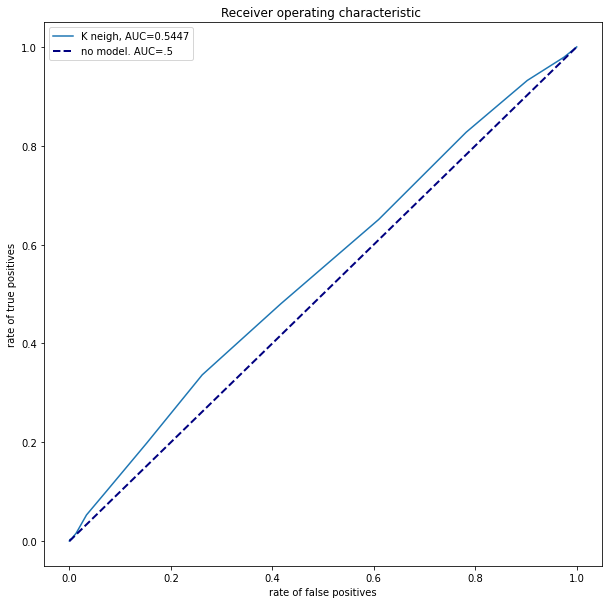



No feature importance


In [80]:
clf_neigh = display_model_results(KNeighborsClassifier(n_neighbors=k_best), 
                      X_train, X_test, y_train, y_test, 
                      'K neigh')

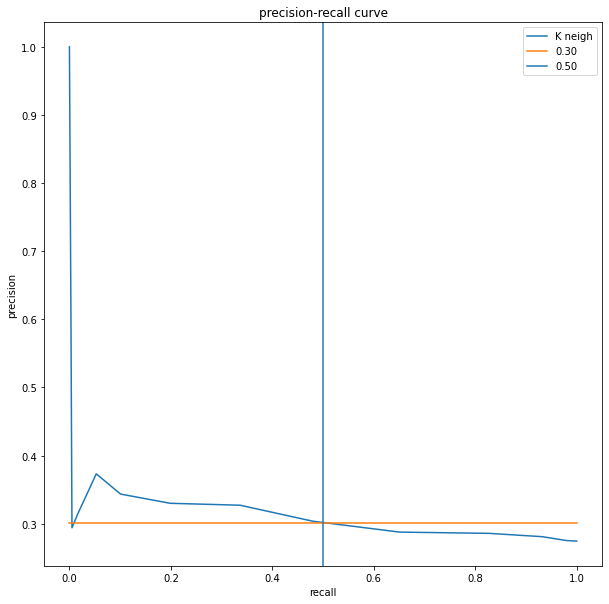



When recall is equal to 0.50, precision is equal to 0.30,and the threshold is equal to 0.33.


In [81]:
recall_value = 0.5 # chose wanted recall value
play_with_threshold(recall_value, y_test, clf_neigh, 'K neigh')

### Random forest

R2 on train set: 0.7305795314426634
R2 on test set: 0.7271232876712329


              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2648
           1       0.67      0.01      0.02      1002

    accuracy                           0.73      3650
   macro avg       0.70      0.50      0.43      3650
weighted avg       0.71      0.73      0.62      3650



Confusion matrix:
[[2642    6]
 [ 990   12]]




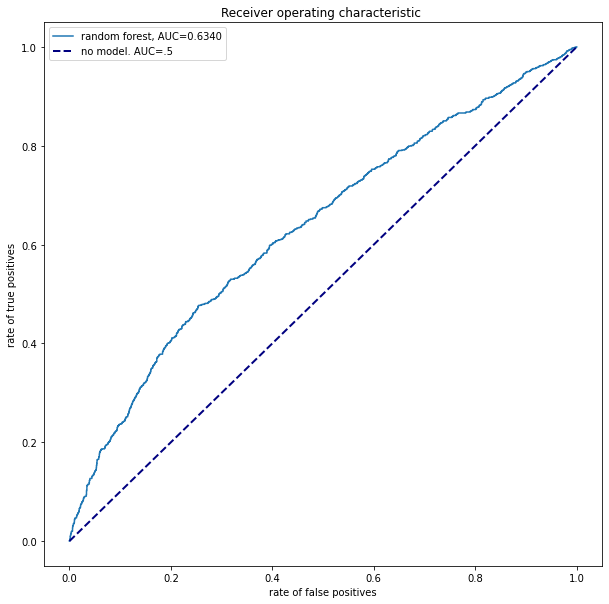



No feature importance


In [82]:
clf_rf = display_model_results(RandomForestClassifier(max_depth=10), 
                      X_train, X_test, y_train, y_test, 
                      'random forest')

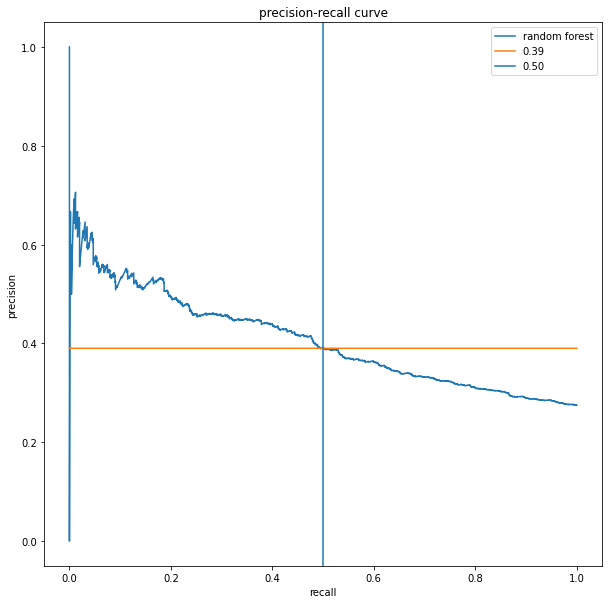



When recall is equal to 0.50, precision is equal to 0.39,and the threshold is equal to 0.31.


In [83]:
recall_value = 0.5 # chose wanted recall value
play_with_threshold(recall_value, y_test, clf_rf, 'random forest')

# TF/IDF only

## Preprocessing

In [37]:
sample_length = len(df)
max_features = 10000

In [38]:
stories_lemma = df.text_str_lem.tolist()[:sample_length]

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3), 
                             max_features=max_features)
X = vectorizer.fit_transform(stories_lemma)

In [40]:
# target
y = df[target]
threshold = np.quantile(y, 0.7)
bn = Binarizer(threshold=threshold).fit(df[[target]])
y = bn.transform(df[[target]])

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y[:sample_length], 
                                                    test_size=0.3, 
                                                    random_state=1)

In [42]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [43]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

## Predictions

### Log regression

R2 on train set: 0.7148672982071557
R2 on test set: 0.7125114155251141


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      3893
           1       0.70      0.01      0.02      1582

    accuracy                           0.71      5475
   macro avg       0.71      0.50      0.42      5475
weighted avg       0.71      0.71      0.60      5475



Confusion matrix:
[[3887    6]
 [1568   14]]




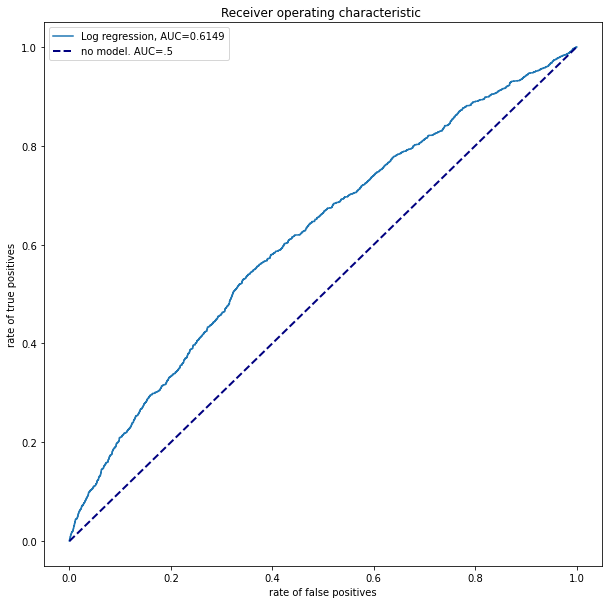



No feature importance


In [44]:
clf_log = display_model_results(LogisticRegression(), 
                      X_train, X_test, y_train, y_test, 
                      'Log regression')

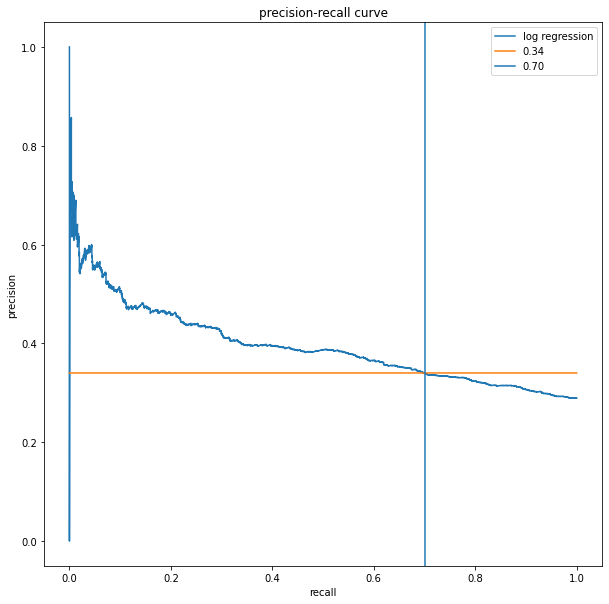



When recall is equal to 0.70, precision is equal to 0.34,and the threshold is equal to 0.27.


In [45]:
recall_value = 0.7 # chose wanted recall value
play_with_threshold(recall_value, y_test, clf_log, 'log regression')

### SVM

In [ ]:
clf_svm = display_model_results(SVC(probability=True), 
                      X_train, X_test, y_train, y_test, 
                      'SVM')

In [ ]:
recall_value = 0.5 # chose wanted recall value
play_with_threshold(recall_value, y_test, clf_svm, 'svm')

### KNN

R2 on train set: 0.7212870899553746
R2 on test set: 0.7024657534246576


              precision    recall  f1-score   support

           0       0.72      0.95      0.82      3893
           1       0.42      0.08      0.14      1582

    accuracy                           0.70      5475
   macro avg       0.57      0.52      0.48      5475
weighted avg       0.63      0.70      0.62      5475



Confusion matrix:
[[3717  176]
 [1453  129]]




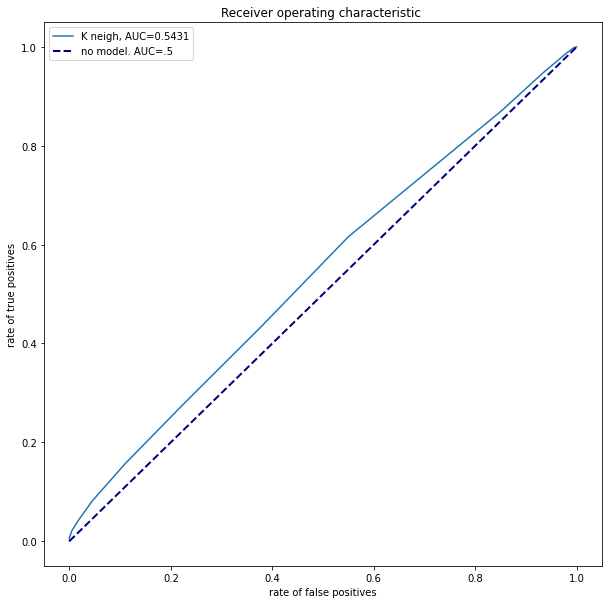



No feature importance


In [46]:
clf_neigh = display_model_results(KNeighborsClassifier(n_neighbors=20), 
                      X_train, X_test, y_train, y_test, 
                      'K neigh')

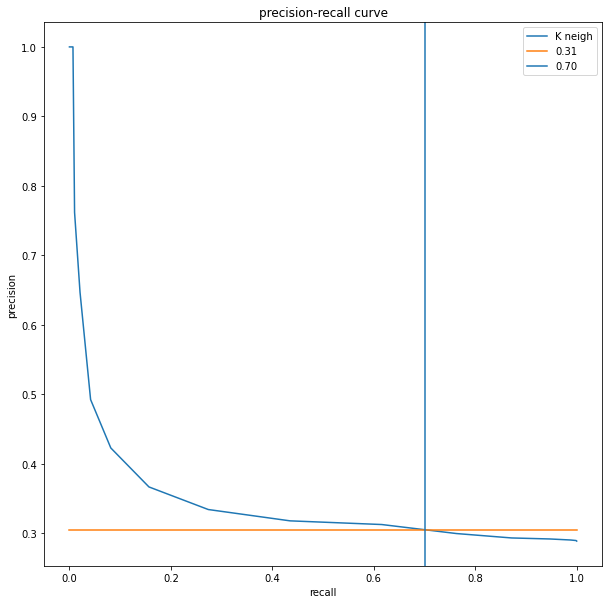



When recall is equal to 0.70, precision is equal to 0.31,and the threshold is equal to 0.32.


In [47]:
recall_value = 0.7 # chose wanted recall value
play_with_threshold(recall_value, y_test, clf_neigh, 'K neigh')

### Random forest

R2 on train set: 0.8259610115086511
R2 on test set: 0.7112328767123288


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      3893
           1       1.00      0.00      0.00      1582

    accuracy                           0.71      5475
   macro avg       0.86      0.50      0.42      5475
weighted avg       0.79      0.71      0.59      5475



Confusion matrix:
[[3893    0]
 [1581    1]]




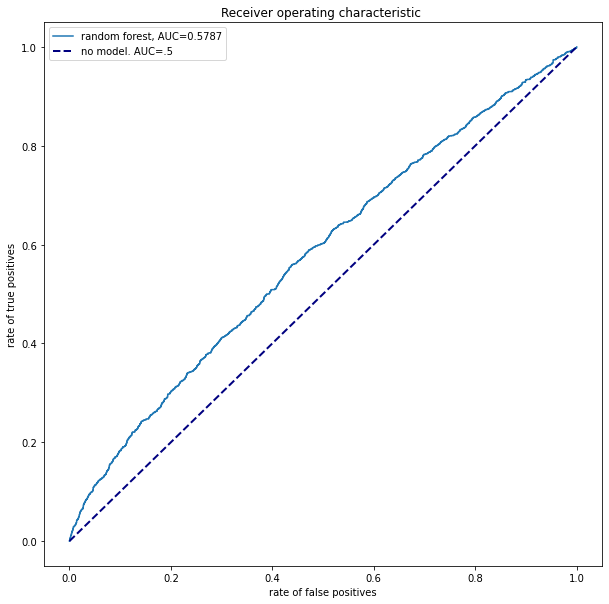



No feature importance


In [48]:
clf_rf = display_model_results(RandomForestClassifier(max_depth=20), 
                      X_train, X_test, y_train, y_test, 
                      'random forest')

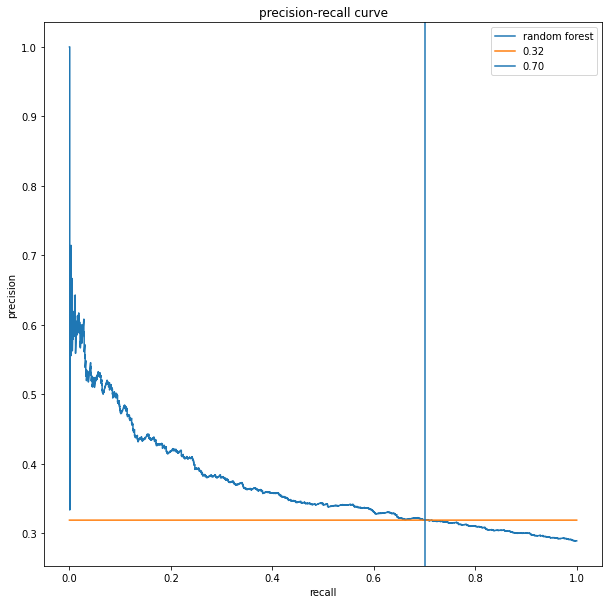



When recall is equal to 0.70, precision is equal to 0.32,and the threshold is equal to 0.27.


In [49]:
recall_value = 0.7 # chose wanted recall value
play_with_threshold(recall_value, y_test, clf_rf, 'random forest')

# TF/IDF and general features (ensembling)

In [ ]:
# X contains the TF/IDF features
X_gen = df[numerical+categories]

In [ ]:
for var_to_log in ['sent_avg_length', 'num_unique_words', 'emotion_love']:
  X_gen[var_to_log] = X[var_to_log].apply(np.log1p)

IndexError: ignored

In [ ]:
# merge X and X_gen
# TODO

In [ ]:
test_size = 20/100

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=42)


In [ ]:
scaler = StandardScaler()
X_train[X_gen.columns] = pd.DataFrame(scaler.fit_transform(X_train[X_gen.columns]), columns=X_gen.columns)
X_test[X_gen.columns] = pd.DataFrame(scaler.transform(X_test[X_gen.columns]), columns=X_gen.columns)

